# Projekt z IWM "Oko"

## Część na 3

Import biblotek

In [1]:
import skimage as ski
from skimage import color, filters
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from PIL import Image
from scipy import ndimage as ndi
import cv2
from sklearn.model_selection import train_test_split
from scipy.stats import gmean
from typing import Literal
import copy
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from skimage import filters
from sklearn.metrics import accuracy_score
import joblib
from random import sample
import time

Ładowanie zdjęć

In [2]:
def loader_image(filename):
    image = ski.io.imread(filename)
    image = image.astype(np.float64)
    image /= np.max(image)
    return image

def tif_loader(mask_filename):
    im = Image.open(mask_filename)
    imarray = np.array(im)
    return imarray

Dla wykrywania naczyń krwionośnych

In [3]:
def get_vessels(retina_source: np.ndarray) -> np.ndarray:
    eye = color.rgb2gray(retina_source)
    x, y = filters.threshold_multiotsu(eye, classes=3)
    mask = (eye > x) #maska, żeby wyodrębnić
    vessels = filters.sato(eye, sigmas=range(1, 15)) * mask
    return vessels

Przeskalowuje intensywność pikseli obrazu, aby wartości znajdowały się w określonym zakresie. (zwiększamy kontrast pikseli)

In [4]:
def get_contrast(image: np.ndarray) -> np.ndarray:
    image = ski.exposure.rescale_intensity(image, in_range=(0.009, 0.015))
    return image

Metoda progowania dla zwiększenia jakości obrazu, niezależnie od get_contrast

In [5]:
def threshold(vessels: np.ndarray) -> np.ndarray:
    thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)
    labeled = ndi.label(thresholded)[0]
    return thresholded

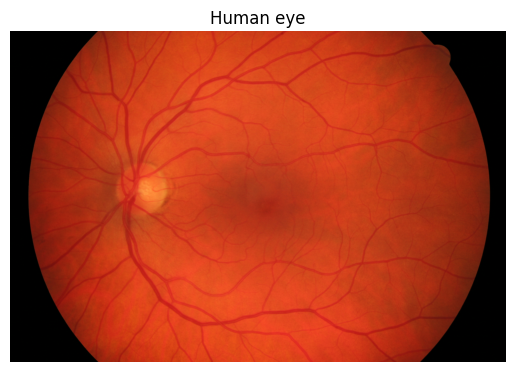

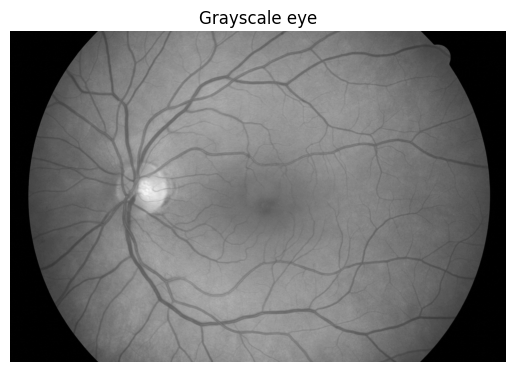

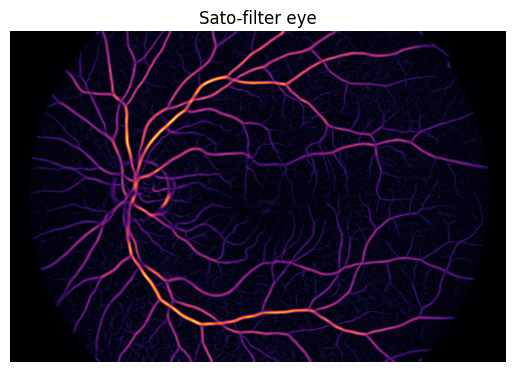

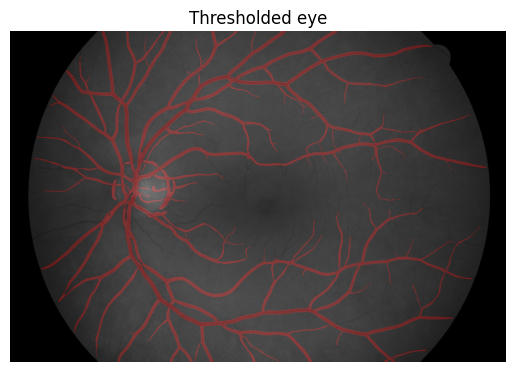

In [6]:
stan_file = 'images/06_h.jpg'
tif_file = 'images/06_h.tif'
mask_tif_file = 'images/01_h_mask.tif'

stan_image = loader_image(stan_file)

plt.figure()
plt.imshow(stan_image)
plt.axis('off')
plt.title('Human eye')
plt.show()

retina = color.rgb2gray(stan_image)

plt.figure()
plt.imshow(retina, cmap='gray')
plt.axis('off')
plt.title('Grayscale eye')
plt.show()

human_retina = get_vessels(stan_image)

plt.figure()
plt.imshow(human_retina, cmap='inferno')
plt.axis('off')
plt.title('Sato-filter eye')
plt.show()

board_level = filters.apply_hysteresis_threshold(human_retina, 0.01, 0.03)
labels = ndi.label(board_level)[0]

plt.figure()
plt.imshow(color.label2rgb(labels, retina))
plt.axis('off')
plt.title('Thresholded eye')
plt.show()

In [7]:
def calculate_metrics(vessels, mask, threshold=0.1):
    binary_predictions = vessels > threshold
    binary_ground_truth = mask > threshold
    
    y_pred = binary_predictions.flatten()
    y_true = binary_ground_truth.flatten()
    
    ground_truth_mask = np.zeros(y_true.shape, dtype=bool)
    ground_truth_mask[y_true > 0] = True

    (width, height) = vessels.shape

    true_positive, false_positive, false_negative, true_negative = 0, 0, 0, 0
    for x in range(width):
        for y in range(height):
            if binary_predictions[x, y]:
                if binary_ground_truth[x, y]:
                    true_positive += 1
                else:
                    false_positive += 1
            else:
                if binary_ground_truth[x, y]:
                    false_negative += 1
                else:
                    true_negative += 1

    evaluation = {}
    evaluation['accuracy'] = (true_positive + true_negative) / (true_negative + false_negative + true_positive + false_positive)
    evaluation['sensitivity'] = true_positive / (true_positive + false_negative)
    evaluation['specificity'] = true_negative / (false_positive + true_negative)
    evaluation['precision'] = true_positive / (true_positive + false_positive)
    evaluation['g_mean'] = np.sqrt(evaluation['sensitivity'] * evaluation['specificity'])
    evaluation['w_average'] = (evaluation['sensitivity'] + evaluation['specificity']) / 2
    evaluation['confusion_matrix'] = metrics.confusion_matrix(ground_truth_mask.flatten(), y_pred.flatten()).flatten()
    
    return evaluation


-------------------------------------------------------------------
Oko numer:  10
-------------------------------------------------------------------


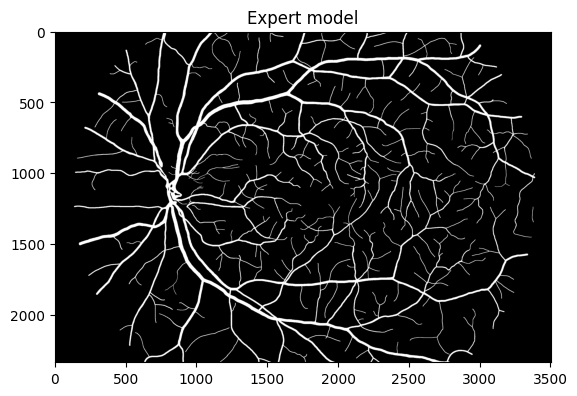

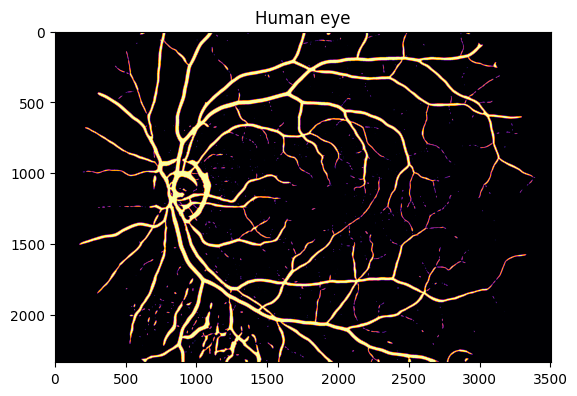

Accuracy score:		 0.95
Sensitivity score:	 0.73
Specificity score:	 0.97
Precision score:	 0.70
G-mean: 		 0.84
Confusion matrix: 	 [7264593  215313  191378  514060]


In [8]:
for i in range(10, 11):
    # import files
    path_folder = 'images/' + str(i) + '_h.jpg'
    path_manual_folder = 'images/' + str(i) + '_h.tif'
    
    image_traditional = loader_image(path_folder)
    image_manual = tif_loader(path_manual_folder)

    print("\n-------------------------------------------------------------------")
    print("Oko numer: ", i)
    print("-------------------------------------------------------------------")
    
    plt.figure()
    plt.imshow(image_manual, cmap='gray')
    plt.title('Expert model')
    plt.show()
    
    human_retina = get_vessels(image_traditional)
    human_retina = get_contrast(human_retina)
    human_retina = threshold(human_retina)
    
    plt.figure()
    plt.imshow(human_retina, cmap='inferno')
    plt.title('Human eye')
    plt.show()
    
    evaluation = calculate_metrics(human_retina, image_manual) # changes returned values to a dictionary
    print(f"Accuracy score:\t\t {evaluation['accuracy']:.2f}")
    print(f"Sensitivity score:\t {evaluation['sensitivity']:.2f}")
    print(f"Specificity score:\t {evaluation['specificity']:.2f}")
    print(f"Precision score:\t {evaluation['precision']:.2f}")
    print(f"G-mean: \t\t {evaluation['g_mean']:.2f}")
    print(f"Confusion matrix: \t {evaluation['confusion_matrix']}")

## Część na 4

Dzieli obraz na fragmenty o określonym rozmiarze i zwraca listę tych fragmentów

In [9]:
def get_fragments(input_image, patch_size=5):
    height, width = input_image.shape[:2]
    patches = []
    for i in range(0, height - patch_size + 1, patch_size):
        for j in range(0, width - patch_size + 1, patch_size):
            patch = input_image[i:i + patch_size, j:j + patch_size].copy()
            patches.append(patch)
    return patches

Wyodrębnia środkowy piksel z każdego fragmentu obrazu, proguje jego wartość i zwraca listę przetworzonych pikseli

In [10]:
def get_mid_px(input_image, patch_size=5):
    height, width = input_image.shape[:2]
    piece = patch_size // 2
    pixels = []
    for i in range(piece, height - piece, patch_size):
        for j in range(piece, width - piece, patch_size):
            pixel = int(input_image[i, j])
            if pixel < 128:
                pixel = 0
            else:
                pixel = 255
            pixels.append(pixel)
            
    return pixels

Ekstrahuje cechy obrazu z podanego spłaszczonego fragmentu obrazu. Oblicza momenty (średnia i wariancja) wartości pikseli oraz histogram wartości pikseli.

In [11]:
def extract_image_features(flat_patch):
    features = []
    moments = [np.mean(flat_patch), np.var(flat_patch)]
    histogram = np.histogram(flat_patch, bins=10)[0]
    features.extend(moments)
    features.extend(histogram)

    return features

Proces uczenia modelu regresji logistycznej na zbiorze obrazów

In [12]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

dataset = []
pixels_of_mask = []

for i in range(1, 6):
    image_set = []
    image = cv2.imread(f'images/0' + str(i) + '_h.jpg')
    mask = cv2.imread(f'images/0' + str(i) + '_h_mask.tif')
    ex_mask = cv2.imread(f'images/0' + str(i) + '_h.tif')

    size_width = 1700
    size_height = 1100

    #wpisanie rozmiarów
    resized_image = cv2.resize(copy.deepcopy(image), (size_width, size_height))
    resized_mask = cv2.resize(mask, (size_width, size_height))
    res_ex_mask = cv2.resize(ex_mask, (size_width, size_height))
    
    #podział na kanały zielone
    green_channel_image = resized_image[:, :, 1]
    expected_result = res_ex_mask[:, :, 1]
    contrasted_image = cv2.equalizeHist(green_channel_image) #równowaga tonalna

    spots = get_fragments(contrasted_image)
    result_patches_pixels = get_mid_px(expected_result)

    #wyodrębniane cech z obrazków i zapisanie tych cech
    for patch in spots:
        flat_patch = patch.flatten().astype(float)
        features = extract_image_features(flat_patch)
        image_set.append(list(flat_patch) + features)

    dataset.extend(image_set)
    pixels_of_mask.extend(result_patches_pixels)

#podział na grupy dla treningu i uczenia
ax_tr, ax_t, ay_tr, ay_t = train_test_split(dataset, pixels_of_mask, test_size=0.5)
#tr - trening, t - test

#skalowanie cech do uczenia i treningu
scaler = StandardScaler()
ax_tr_transformed = scaler.fit_transform(ax_tr)
ax_t_transformed = scaler.transform(ax_t)

model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(ax_tr_transformed, ay_tr)
y_predicted = model.predict(ax_t_transformed)

accuracy = accuracy_score(ay_t, y_predicted)
print(f"Accuracy Score: {accuracy}")

joblib.dump(scaler, 'scaler.bin', compress=3)
joblib.dump(model, 'model.bin', compress=3)

Accuracy Score: 0.951331550802139


['model.bin']


-------------------------------------------------------------------
Oko Machine Learning:  6
-------------------------------------------------------------------


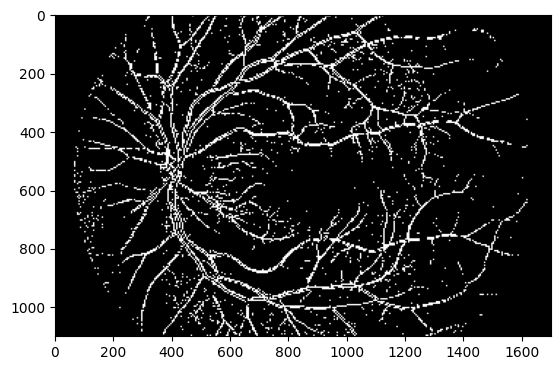

Accuracy 06:	 91.53
Sensitivity 06:	 53.11
Specificity 06:	 96.47
Confusion 06:	 [1598439   58549   99886  113126]

-------------------------------------------------------------------
Oko Machine Learning:  7
-------------------------------------------------------------------


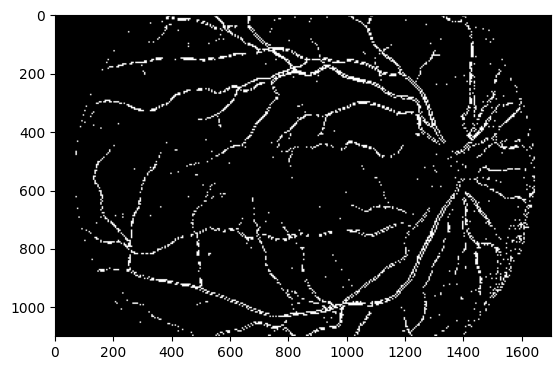

Accuracy 07:	 92.50
Sensitivity 07:	 38.72
Specificity 07:	 98.43
Confusion 07:	 [1657733   26418  113892   71957]

-------------------------------------------------------------------
Oko Machine Learning:  8
-------------------------------------------------------------------


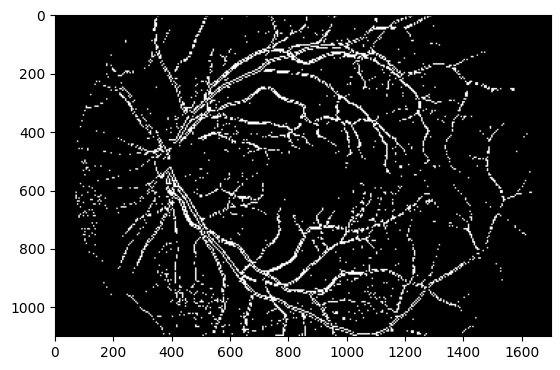

Accuracy 08:	 91.42
Sensitivity 08:	 44.73
Specificity 08:	 97.31
Confusion 08:	 [1615959   44713  115691   93637]

-------------------------------------------------------------------
Oko Machine Learning:  9
-------------------------------------------------------------------


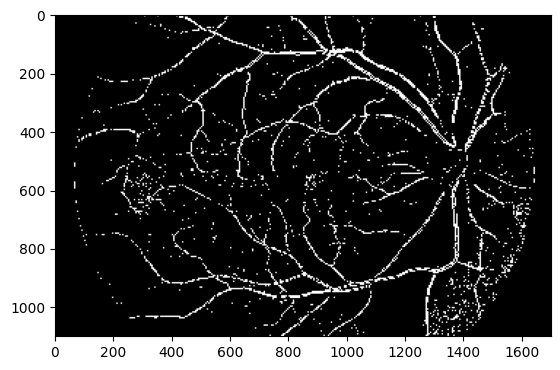

Accuracy 09:	 93.22
Sensitivity 09:	 45.82
Specificity 09:	 97.81
Confusion 09:	 [1667548   37407   89427   75618]


In [15]:
classifier = joblib.load('model.bin')
scaler = joblib.load('scaler.bin')

for image_number in range(6, 10):
    image_path = f'images/{image_number:02d}_h.jpg'
    mask_path = f'images/{image_number:02d}_h_mask.tif'
    expected_result_path = f'images/{image_number:02d}_h.tif'

    size_width = 1700
    size_height = 1100

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    expected_result = cv2.imread(expected_result_path)

    resized_image = cv2.resize(copy.deepcopy(image), (size_width, size_height))

    green_channel_image = resized_image[:, :, 1]
    green_channel_mask = mask[:, :, 1]
    expected_result = expected_result[:, :, 1]

    expected_result = cv2.resize(expected_result, (size_width, size_height))

    image_contrasted = cv2.equalizeHist(green_channel_image)

    spots = get_fragments(image_contrasted)

    array_image = []
    for patch in spots:
        flat_patch = patch.flatten().astype(float)
        features = extract_image_features(flat_patch)
        array_image.append(list(flat_patch) + features)

    ax_t_transformed = scaler.transform(array_image)

    machine_image = classifier.predict(ax_t_transformed)

    height, width, channels = resized_image.shape
    new_image = np.zeros((height, width))

    for x in range(0, height, 5):
        for y in range(0, width, 5):
            new_image[x:x+5, y:y+5] = machine_image[0]
            machine_image = machine_image[1:]

    normalized_image = (new_image / np.max(new_image)) * 255

    pil_image = Image.fromarray(normalized_image)
  #  pil_image = pil_image.convert('L')
    
    
    print("\n-------------------------------------------------------------------")
    print("Oko Machine Learning: ", image_number)
    print("-------------------------------------------------------------------")

    plt.imshow(normalized_image, cmap='gray')
    plt.show()

    evaluation = calculate_metrics(normalized_image, expected_result)
    print(f"Accuracy {image_number:02d}:\t {evaluation['accuracy']*100:.2f}")
    print(f"Sensitivity {image_number:02d}:\t {evaluation['sensitivity']*100:.2f}")
    print(f"Specificity {image_number:02d}:\t {evaluation['specificity']*100:.2f}")
    print(f"Confusion {image_number:02d}:\t {evaluation['confusion_matrix']}")